In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load the dataset for recommenders

In [5]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [6]:
def n_to_p(l):
    n = sum(l)
    return [x / n for x in l] if n > 0 else l

def calculate_p(x, values):
    counts = [0]*len(values)
    for v in x:
        counts[values.index(v)] += 1

    return n_to_p(counts)

def prepare_users_df(interactions_df):

    users_df = interactions_df.loc[:, ["user_id"]]
    users_df = users_df.groupby("user_id").first().reset_index(drop=False)
    
    user_features = []

    for column in base_item_features:

        column_values = column_values_dict[column]
        df = interactions_df.loc[:, ['user_id', column]]
        df = df.groupby('user_id').aggregate(lambda x: list(x)).reset_index(drop=False)

        def calc_p(x):
            return calculate_p(x, column_values)

        df.loc[:, column] = df[column].apply(lambda x: calc_p(x))

        p_columns = []
        for i in range(len(column_values)):
            p_columns.append("user_" + column + "_" + column_values[i])
            df.loc[:, p_columns[i]] = df[column].apply(lambda x: x[i])
            user_features.append(p_columns[i])

        users_df = pd.merge(users_df, df.loc[:, ['user_id'] + p_columns], on=["user_id"])
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,0.130435,0.0,0.652174,0.086957,0.130435,0.000000,0.000000,0.000000,0.000000,0.608696,0.391304,0.000000,0.521739,0.478261,0.000000,0.869565,0.130435,0.000000,0.0,0.000000,0.739130,0.173913,0.086957,0.782609,0.217391
47,50,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.000000,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.000000,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
92,96,0.083333,0.0,0.708333,0.125000,0.041667,0.041667,0.000000,0.000000,0.250000,0.666667,0.041667,0.041667,0.291667,0.708333,0.125000,0.791667,0.083333,0.000000,0.0,0.041667,0.333333,0.541667,0.083333,0.750000,0.250000
111,115,0.727273,0.0,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.363636,0.136364,0.000000,1.000000,0.000000,0.000000,0.818182,0.181818,0.000000,0.0,0.818182,0.090909,0.045455,0.045455,0.363636,0.636364
675,706,0.091988,0.0,0.451039,0.189911,0.207715,0.038576,0.011869,0.008902,0.169139,0.459941,0.272997,0.097923,0.994065,0.005935,0.020772,0.839763,0.130564,0.008902,0.0,0.041543,0.094955,0.738872,0.124629,0.676558,0.323442
1699,1736,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.000000,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.068966,0.000000,0.0,0.379310,0.413793,0.206897,0.000000,0.448276,0.551724
7639,7779,0.037037,0.0,0.296296,0.259259,0.370370,0.000000,0.000000,0.037037,0.111111,0.296296,0.481481,0.111111,1.000000,0.000000,0.000000,0.814815,0.185185,0.000000,0.0,0.000000,0.037037,0.740741,0.222222,0.814815,0.185185


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [7]:
def map_items_to_onehot(df):
    one_hot = pd.get_dummies(df.loc[:, base_item_features])
    df = df.drop(base_item_features, axis = 1)
    df = df.join(one_hot)
    
    return df, list(one_hot.columns)

def prepare_items_df(interactions_df):
    items_df = interactions_df.loc[:, ["item_id"] + base_item_features].drop_duplicates()
    
    items_df, item_features = map_items_to_onehot(items_df)
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['term_WinterVacation', 'term_Easter', 'term_OffSeason', 'term_HighSeason', 'term_LowSeason', 'term_MayLongWeekend', 'term_NewYear', 'term_Christmas', 'length_of_stay_bucket_[0-1]', 'length_of_stay_bucket_[2-3]', 'length_of_stay_bucket_[4-7]', 'length_of_stay_bucket_[8-inf]', 'rate_plan_Standard', 'rate_plan_Nonref', 'room_segment_[0-160]', 'room_segment_[160-260]', 'room_segment_[260-360]', 'room_segment_[360-500]', 'room_segment_[500-900]', 'n_people_bucket_[1-1]', 'n_people_bucket_[2-2]', 'n_people_bucket_[3-4]', 'n_people_bucket_[5-inf]', 'weekend_stay_True', 'weekend_stay_False']


,item_id,term_WinterVacation,term_Easter,term_OffSeason,term_HighSeason,term_LowSeason,term_MayLongWeekend,term_NewYear,term_Christmas,length_of_stay_bucket_[0-1],length_of_stay_bucket_[2-3],length_of_stay_bucket_[4-7],length_of_stay_bucket_[8-inf],rate_plan_Standard,rate_plan_Nonref,room_segment_[0-160],room_segment_[160-260],room_segment_[260-360],room_segment_[360-500],room_segment_[500-900],n_people_bucket_[1-1],n_people_bucket_[2-2],n_people_bucket_[3-4],n_people_bucket_[5-inf],weekend_stay_True,weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [8]:
class NNM(nn.Module):

    """    
        features:            
            Number of input features
        drop_out: 
            Dropout rate to apply after Relu layer.
        neurons:
            Number of hidden layer neurons.
    """
    
    def __init__(self, features, drop_out, neurons, seed=6789):
        self.seed = torch.manual_seed(seed)
        super(NNM, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(features, neurons),
            nn.ReLU(),
            nn.Dropout(drop_out * 0.5),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(neurons, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [9]:
from recommenders.recommender import Recommender


class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5, epochs=10, batch_size=100, drop_out = 0.5, learning_rate=0.001, neurons=100):
        """
        Initialize base recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.drop_out = drop_out
        self.learning_rate = learning_rate
        self.neurons = int(neurons)
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        interactions_df = interactions_df.copy()
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df, user_features = prepare_users_df(interactions_df)
        
        self.users_df = users_df
        self.user_features = user_features
        
        items_df, item_features = prepare_items_df(interactions_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Generate negative interactions
        
        interactions_df = interactions_df.loc[:, ['user_id', 'item_id']]
        
        interactions_df.loc[:, 'interacted'] = 1
        
        negative_interactions = []
        
        unique_item_id = interactions_df['item_id'].drop_duplicates().values.tolist()

        # Write your code here
        # Generate tuples (user_id, item_id, 0) for pairs (user_id, item_id) which do not
        # appear in the interactions_df and add those tuples to the list negative_interactions.
        # Generate self.n_neg_per_pos * len(interactions_df) negative interactions
        # (self.n_neg_per_pos per one positive).
        # Make sure the code is efficient and runs fast, otherwise you will not be able to properly tune your model.
        
        for user_id, item_gruped_by_user in interactions_df.groupby('user_id'):
            items_by_user = item_gruped_by_user['item_id'].values.tolist()
            posible_items_id = list(set(unique_item_id) - set(items_by_user))
            for item in items_by_user:
                for x in range(self.n_neg_per_pos):
                    random_item_id = self.rng.choice(posible_items_id)
                    negative_interactions.append((user_id, random_item_id, 0))
                # Not delete used item id from posible_items_id because it is not enough id e.g. for user 706
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])
        
        x = interactions_df.loc[:, user_features + item_features].values
        y = interactions_df['interacted'].values
        
        x_size = len(x[0])
        y_size = y.shape[0]
        # Initialize the neural network model
        
        self.model = NNM(features=x_size, drop_out=self.drop_out, neurons=self.neurons, seed=self.seed)
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        batch_size = self.batch_size
        
        # Train the model using an optimizer
        for epoch in range(self.epochs):
            for b in range((y_size-1)//batch_size + 1):
                start_b = b*batch_size
                end_b = start_b+batch_size
                xb = x[start_b:end_b]
                yb = y[start_b:end_b]
                X_train = torch.tensor(xb.astype(np.float32))
                Y_train = torch.tensor(yb.astype(np.float32)).reshape(-1, 1)
                Y_predict = self.model(X_train)
                loss = self.loss(Y_predict, Y_train)
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print(epoch)
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        items_df, item_features = prepare_items_df(items_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Score the items
    
        recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        
        for ix, user in users_df.iterrows():
            
            # Calculate the score for the user and every item in items_df
            
            user['key'] = 1
            items_df['key'] = 1
            user = user.to_frame().transpose()
            carthesian_user_items = user.merge(items_df, on='key').drop("key", 1)
            
            x = carthesian_user_items.loc[:, user_features + item_features].values
            self.model.eval() 
            scores = self.model(torch.tensor(x.astype(np.float32)))
            scores = scores.detach().numpy()[:, 0]
            
            chosen_ids = np.argsort(-scores)[:n_recommendations]
            
            recommendations = []
            for item_id in chosen_ids:
                recommendations.append(
                    {
                        'user_id': user['user_id'].iloc[0],
                        'item_id': item_id,
                        'score': scores[item_id]
                    }
                )
            
            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [10]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

In [11]:
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

0
1
2
3
4
5
6
7
8
9


In [13]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,41,0.413413,OffSeason,[2-3],Standard,[160-260],[2-2],True
1,1.0,103,0.370612,OffSeason,[2-3],Nonref,[160-260],[2-2],True
2,1.0,28,0.338627,OffSeason,[2-3],Standard,[160-260],[3-4],True
3,1.0,99,0.324248,OffSeason,[2-3],Nonref,[160-260],[3-4],True
4,1.0,29,0.313964,OffSeason,[4-7],Standard,[160-260],[2-2],True
5,1.0,26,0.291911,OffSeason,[2-3],Standard,[160-260],[2-2],False
6,1.0,109,0.275309,OffSeason,[4-7],Nonref,[160-260],[2-2],True
7,1.0,16,0.249357,OffSeason,[4-7],Standard,[160-260],[3-4],True
8,1.0,101,0.219048,OffSeason,[2-3],Nonref,[160-260],[2-2],False
9,1.0,122,0.215802,OffSeason,[4-7],Nonref,[160-260],[3-4],True


# Tuning method

In [19]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [20]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [23]:
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 10, 20, 2),
    'epochs': hp.quniform('epochs', 10, 50, 10),
    'batch_size': hp.quniform('batch_size', 100, 500, 100),
    'drop_out' : hp.quniform('drop_out', 0.1, 1, 0.1),
    'learning_rate': hp.quniform('learning_rate', 0.0005, 0.005, 0.0005),
    'neurons': hp.quniform('neurons', 100, 300, 100)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=50, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

0                                                                                                                      
1                                                                                                                      
2                                                                                                                      
3                                                                                                                      
4                                                                                                                      
5                                                                                                                      
6                                                                                                                      
7                                                                                                                      
8                                       

48                                                                                                                     
49                                                                                                                     
0                                                                                                                      
1                                                                                                                      
2                                                                                                                      
3                                                                                                                      
4                                                                                                                      
5                                                                                                                      
6                                       

6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                      

4                                                                                                                      
5                                                                                                                      
6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                      

22                                                                                                                     
23                                                                                                                     
24                                                                                                                     
25                                                                                                                     
26                                                                                                                     
27                                                                                                                     
28                                                                                                                     
29                                                                                                                     
30                                      

20                                                                                                                     
21                                                                                                                     
22                                                                                                                     
23                                                                                                                     
24                                                                                                                     
25                                                                                                                     
26                                                                                                                     
27                                                                                                                     
28                                      

8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                                                                                                     
15                                                                                                                     
16                                      

6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                      

34                                                                                                                     
35                                                                                                                     
36                                                                                                                     
37                                                                                                                     
38                                                                                                                     
39                                                                                                                     
0                                                                                                                      
1                                                                                                                      
2                                       

22                                                                                                                     
23                                                                                                                     
24                                                                                                                     
25                                                                                                                     
26                                                                                                                     
27                                                                                                                     
28                                                                                                                     
29                                                                                                                     
30                                      

10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                                                                                                     
15                                                                                                                     
16                                                                                                                     
17                                                                                                                     
18                                      

18                                                                                                                     
19                                                                                                                     
0                                                                                                                      
1                                                                                                                      
2                                                                                                                      
3                                                                                                                      
4                                                                                                                      
5                                                                                                                      
6                                       

6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
0                                                                                                                      
1                                                                                                                      
2                                                                                                                      
3                                                                                                                      
4                                       

14                                                                                                                     
15                                                                                                                     
16                                                                                                                     
17                                                                                                                     
18                                                                                                                     
19                                                                                                                     
20                                                                                                                     
21                                                                                                                     
22                                      

2                                                                                                                      
3                                                                                                                      
4                                                                                                                      
5                                                                                                                      
6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
10                                      

0                                                                                                                      
1                                                                                                                      
2                                                                                                                      
3                                                                                                                      
4                                                                                                                      
5                                                                                                                      
6                                                                                                                      
7                                                                                                                      
8                                       

18                                                                                                                     
19                                                                                                                     
20                                                                                                                     
21                                                                                                                     
22                                                                                                                     
23                                                                                                                     
24                                                                                                                     
25                                                                                                                     
26                                      

6                                                                                                                      
7                                                                                                                      
8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                      

24                                                                                                                     
25                                                                                                                     
26                                                                                                                     
27                                                                                                                     
28                                                                                                                     
29                                                                                                                     
30                                                                                                                     
31                                                                                                                     
32                                      

12                                                                                                                     
13                                                                                                                     
14                                                                                                                     
15                                                                                                                     
16                                                                                                                     
17                                                                                                                     
18                                                                                                                     
19                                                                                                                     
20                                      

30                                                                                                                     
31                                                                                                                     
32                                                                                                                     
33                                                                                                                     
34                                                                                                                     
35                                                                                                                     
36                                                                                                                     
37                                                                                                                     
38                                      

8                                                                                                                      
9                                                                                                                      
10                                                                                                                     
11                                                                                                                     
12                                                                                                                     
13                                                                                                                     
14                                                                                                                     
15                                                                                                                     
16                                      

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.053307,0.130964,0.180322,0.24383,0.053307,0.098124,0.118012,0.138456


Best parameters:
{'batch_size': 300.0, 'drop_out': 0.7000000000000001, 'epochs': 30.0, 'learning_rate': 0.001, 'n_neg_per_pos': 12.0, 'neurons': 300.0}


# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

In [24]:
nn_recommender = NNRecommender(n_neg_per_pos=12, epochs=30, batch_size=300, drop_out=0.7, learning_rate=0.001, neurons=300)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.053307,0.130964,0.180322,0.24383,0.053307,0.098124,0.118012,0.138456


In [25]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.042777,0.105298,0.141165,0.200395,0.042777,0.077484,0.092455,0.111472


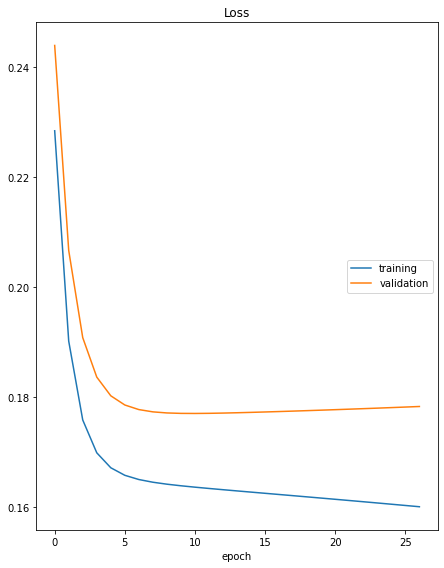

Loss
	training         	 (min:    0.160, max:    0.228, cur:    0.160)
	validation       	 (min:    0.177, max:    0.244, cur:    0.178)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.042777,0.105298,0.143139,0.200066,0.042777,0.077484,0.093234,0.111379


In [26]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(n_epochs=30, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [27]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.053307,0.130964,0.180322,0.243830,0.053307,0.098124,0.118012,0.138456
1,AmazonRecommender,0.042777,0.105298,0.141165,0.200395,0.042777,0.077484,0.092455,0.111472
2,NetflixRecommender,0.042777,0.105298,0.143139,0.200066,0.042777,0.077484,0.093234,0.111379


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [ ]:
Did not work:
    - hidden layer between Relu layers,
    - layer reducing the number of features.
How to improve NNM:
    - use CUDA technology,
    - experiment with features.